In [ ]:
if (!require("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install

In [ ]:
BiocManager::install("biomaRt")
library(biomaRt)

In [ ]:
library(BiocManager)
BiocManager::install('GOstats')
BiocManager::install("clusterProfiler")
BiocManager::install("org.Hs.eg.db")
BiocManager::install("enrichplot")
#BiocManager::install("Rtools")

In [1]:
library(biomaRt)
library(org.Hs.eg.db)
library(clusterProfiler)
# Leer el archivo CSV
data <- read.csv("deSeqRes_filtrado_Lactobacillus_acidophilus_KLDS1.0901.csv")
# Filtrar los genes significativos
genes_significativos <- subset(data, padj < 0.05)
# Extraer la lista de genes significativos
lista_genes <- genes_significativos$gene_name
# Verificar si los genes son números (posiblemente IDs de Entrez)
if (all(grepl("^\\d+$", lista_genes))) {
    genes_ids <- lista_genes
} else {
    # Convertir los nombres de genes a IDs de Entrez si son símbolos
    genes_ids <- bitr(lista_genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db)$ENTREZID
}
genes_ids

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: IRanges

Loading required package: S4Vectors

[1] "220"  "3576" "1958" "6559"

In [2]:

# Convertir los IDs de Entrez a nombres de genes si son IDs de Entrez
if (all(grepl("^\\d+$", genes_ids))) {
    # Crear una conexión a la base de datos de biomart
    mart <- useMart(biomart = "ensembl", dataset = "hsapiens_gene_ensembl")
    
    # Obtener los nombres de los genes correspondientes a los IDs de Entrez
    gene_info <- getBM(attributes = c("entrezgene_id", "external_gene_name"), 
                       filters = "entrezgene_id", 
                       values = genes_ids, 
                       mart = mart)
    
    # Reemplazar los IDs de Entrez por los nombres de los genes convertidos
    genes_names <- gene_info$external_gene_name
}



In [3]:
genes_names

[1] "EGR1"    "ALDH1A3" "CXCL8"   "SLC12A3"

In [4]:
# Conectarse a la base de datos UniProt usando el conjunto de datos 'hsapiens_gene_ensembl'
ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")

In [5]:
# Obtener la información de las proteínas correspondientes a los nombres de los genes
info_proteinas <- getBM(attributes = c("ensembl_gene_id", "external_gene_name", "uniprotswissprot", "description"),
                        filters = "external_gene_name",
                        values = genes_names,
                        mart = mart)

In [6]:
# Filtrar para obtener solo los genes que codifican proteínas
genes_codifican_proteinas <- info_proteinas[info_proteinas$uniprotswissprot != "", ]

# Mostrar los resultados
genes_codifican_proteinas

,ensembl_gene_id,external_gene_name,uniprotswissprot,description
,<chr>,<chr>,<chr>,<chr>
2,ENSG00000184254,ALDH1A3,P47895,aldehyde dehydrogenase 1 family member A3 [Source:HGNC Symbol;Acc:HGNC:409]
3,ENSG00000070915,SLC12A3,P55017,solute carrier family 12 member 3 [Source:HGNC Symbol;Acc:HGNC:10912]
6,ENSG00000169429,CXCL8,P10145,C-X-C motif chemokine ligand 8 [Source:HGNC Symbol;Acc:HGNC:6025]
7,ENSG00000120738,EGR1,P18146,early growth response 1 [Source:HGNC Symbol;Acc:HGNC:3238]


In [7]:
# Lista de genes que codifican proteínas
genes_codifican_proteinas <- unique(genes_codifican_proteinas$external_gene_name)

# Verificar la presencia de cada gen en genes_codifican_proteinas
genes_presentes <- genes_names %in% genes_codifican_proteinas

# Mostrar los genes que están en genes_codifican_proteinas
genes_encontrados <- genes_names[genes_presentes]
cat("Genes encontrados:\n")
print(genes_encontrados)

# Mostrar los genes que no están en genes_codifican_proteinas
genes_no_encontrados <- genes_names[!genes_presentes]
cat("Genes no encontrados:\n")
print(genes_no_encontrados)

Genes encontrados:


[1] "EGR1"    "ALDH1A3" "CXCL8"   "SLC12A3"
Genes no encontrados:
character(0)


In [8]:
# Obtener los nombres de las proteínas correspondientes a los genes encontrados
proteinas <- getBM(
  attributes = c("external_gene_name", "uniprotswissprot"),
  filters = "external_gene_name",
  values = genes_encontrados,
  mart = ensembl
)

# Filtrar las filas donde el campo uniprotswissprot no esté vacío
proteinas_filtradas <- proteinas[proteinas$uniprotswissprot != "", ]

# Mostrar los nombres de las proteínas
cat("Nombres de las proteínas correspondientes a los genes encontrados:\n")
print(proteinas_filtradas$uniprotswissprot)

Nombres de las proteínas correspondientes a los genes encontrados:
[1] "P47895" "P55017" "P10145" "P18146"


In [19]:
# Filtrar las filas donde el campo uniprotswissprot no esté vacío
proteinas_filtradas <- proteinas[proteinas$uniprotswissprot != "", ]

# Obtener solo la columna de nombres de proteínas
lista_proteinas <- proteinas_filtradas$uniprotswissprot


# Guardar la lista de proteínas en una variable
lista_proteinas

[1] "P47895" "P55017" "P10145" "P18146"

In [16]:
# Asegúrate de que lista_proteinas sea un vector
lista_proteinas_2 <- as.character(lista_proteinas)

# Guardar la lista de proteínas en un archivo CSV sin la columna X y sin comillas
writeLines(lista_proteinas_2, "lista_proteinas_Lactobacillus_acidophilus_KLDS1.0901.csv")

In [17]:
# Cargar el archivo CSV de nuevo en R
lista_proteinas_cargado <- read.csv("lista_proteinas_Lactobacillus_acidophilus_KLDS1.0901.csv", header = FALSE)

# Renombrar la columna si es necesario
colnames(lista_proteinas_cargado) <- "uniprotswissprot"

In [18]:
lista_proteinas_cargado

uniprotswissprot
<chr>
P47895
P55017
P10145
P18146


BIOGRID

In [15]:
# Ejemplo de consulta a BioGRID
library(RCurl)  # Para realizar solicitudes HTTP
library(XML)    # Para trabajar con XML/HTML
library(httr)
library(biomaRt)
library(org.Hs.eg.db)



Attaching package: 'httr'


The following object is masked from 'package:Biobase':

    content




In [16]:
# Ejemplo de consulta a BioGRID utilizando una API (adaptar según la API específica)
base_url <- "http://webservice.thebiogrid.org"
method <- "/interactions"

In [23]:
# Definir la URL de la API BioGRID para obtener las interacciones del gen MDM2
# Ejemplo de consulta a BioGRID utilizando una API (adaptar según la API específica)
base_url <- "http://webservice.thebiogrid.org"
method <- "/interactions"
api_key <- "2a4e2455be91b4c686b17f26b16cdeb9"

# Construir la URL de consulta con parámetros adecuados para genes
query_url <- paste(base_url, method, "?geneList=", paste(genes_ids, collapse = "|"), "&searchids=true&includeInteractors=true&accesskey=", api_key, sep = "")

# Realizar la solicitud HTTP
result <- getURL(query_url)

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
"EOF within quoted string"
Warning message:
"package 'igraph' was built under R version 4.3.3"

Attaching package: 'igraph'


The following object is masked from 'package:clusterProfiler':

    simplify


The following object is masked from 'package:IRanges':

    union


The following object is masked from 'package:S4Vectors':

    union


The following objects are masked from 'package:BiocGenerics':

    normalize, path, union


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




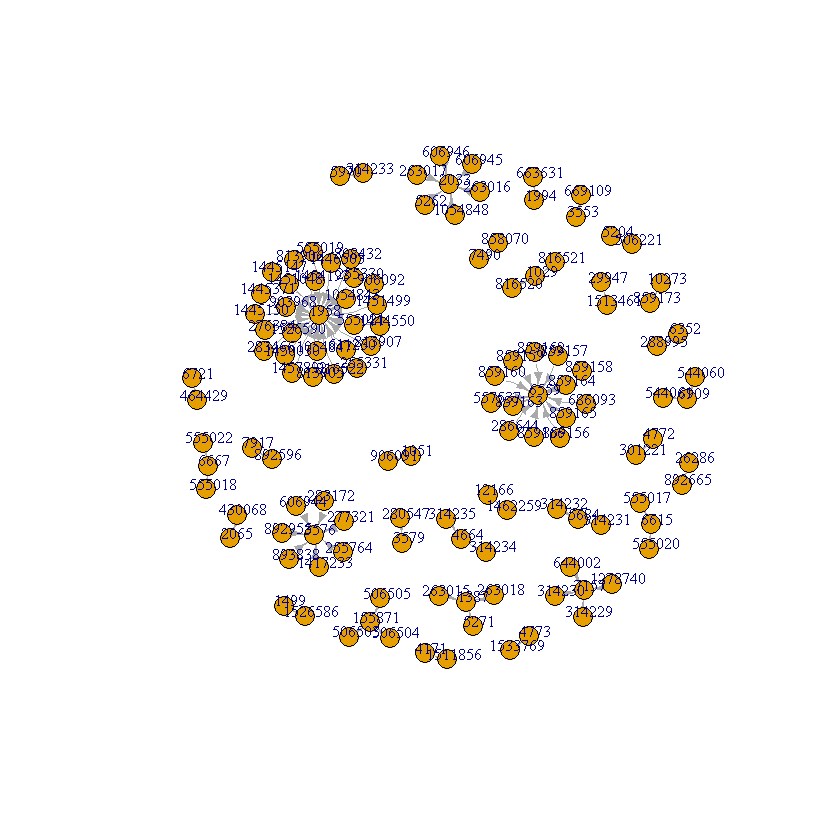

In [18]:
# Suponiendo que `result` contiene los datos de interacciones de BioGRID en formato TSV

#Intenta leer el archivo TSV con manejo de líneas incompletas
interacciones <- read.table(text = result, sep = "\t", header = FALSE, fill = TRUE)

# Verificar si se leyeron datos válidos
if (length(interacciones) > 0) {
  # Asignar nombres de columnas según la estructura de BioGRID
  col_names <- c("ID1", "ID2", "Gen1", "Gen2", "Método", "Tipo", 
                 "Autor", "ID_Pub", "Tax1", "Tax2", "Calidad",
                 rep("-", times = ncol(interacciones) - 11), "BaseDatos")
  
  # Ajustar el vector de nombres si es necesario (puede ser que BioGRID devuelva menos columnas)
  col_names <- head(col_names, ncol(interacciones))
  
  # Asignar nombres de columnas
  colnames(interacciones) <- col_names
  
  # Seleccionar solo las columnas relevantes (por ejemplo, ID1 e ID2 son los identificadores de proteínas)
  interacciones <- interacciones[, c("ID1", "ID2")]
  
  # Verificar si hay filas duplicadas y eliminarlas si es necesario
  interacciones <- unique(interacciones)
  
  
  # Crear un grafo dirigido usando igraph
  library(igraph)
  
  # Crear un grafo vacío con los nodos de interacciones únicas
  grafo <- graph_from_data_frame(d = interacciones, directed = TRUE)
  
  # Ajustar el layout para evitar superposiciones
  layout <- layout_with_fr(grafo, weights = E(grafo)$weight)
  
  # Visualizar el grafo con un layout personalizado
  plot(grafo, layout = layout, vertex.label.dist = 0.5, vertex.size = 8, edge.arrow.size = 0.5,
       vertex.label.cex = 0.8, edge.curved = 0.2, margin = 0.1)
  
} else {
  # Manejar el caso de que no se hayan leído datos válidos
  print("No se pudieron leer datos válidos.")
}


Para ver la lista de organismos disponibles, sólo están: 224308	Bacillus subtilis (168)

https://webservice.thebiogrid.org/organisms/?accesskey=2a4e2455be91b4c686b17f26b16cdeb9

In [99]:
# Filtrar interacciones entre Homo sapiens y Fusobacterium
interacciones_human_fusobacterium <- interacciones[
  (interacciones$Tax1 == "Homo sapiens" & grepl("Fusobacterium", interacciones$Tax2)) |
  (interacciones$Tax2 == "Homo sapiens" & grepl("Fusobacterium", interacciones$Tax1)),
]

# Mostrar las interacciones encontradas
print(interacciones_human_fusobacterium)


 [1] V1  V2  V3  V4  V5  V6  V7  V8  V9  V10 V11 V12 V13 V14 V15 V16 V17 V18 V19
[20] V20 V21 V22 V23 V24
<0 rows> (or 0-length row.names)



Para analizar las rutas implicadas en las interacciones proteína-proteína, generalmente se ineteresa más las interacciones físicas. Esto se debe a que las interacciones físicas suelen implicar un contacto directo entre las proteínas, formando complejos proteicos que están directamente involucrados en procesos celulares y biológicos específicos. Estas interacciones son fundamentales para comprender cómo las proteínas cooperan entre sí para llevar a cabo funciones biológicas.

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
"EOF within quoted string"


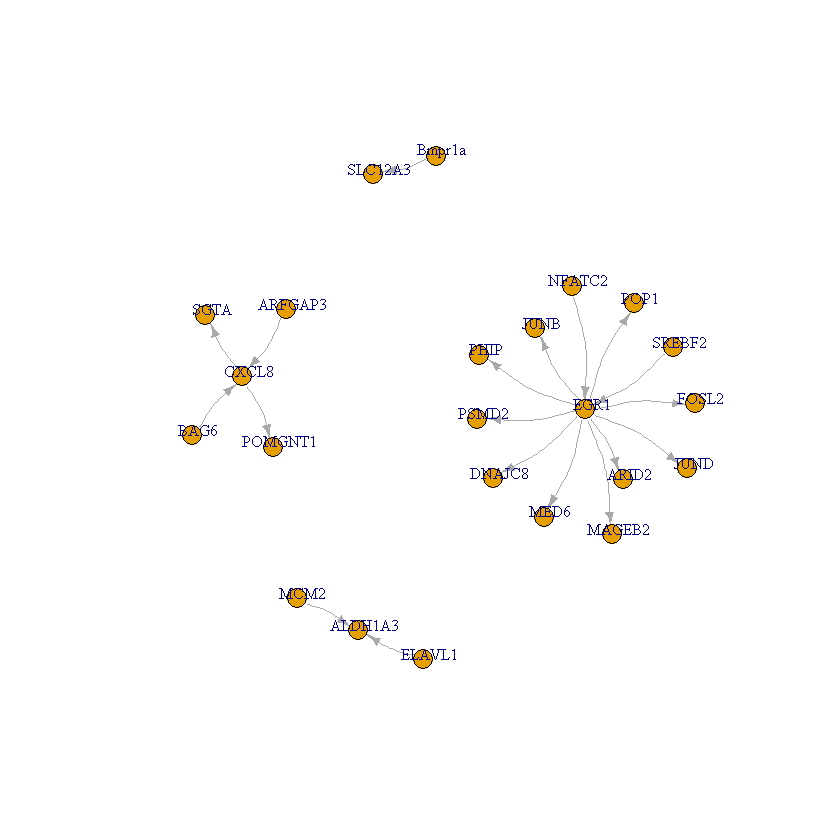

In [40]:
#Intenta leer el archivo TSV con manejo de líneas incompletas
interacciones <- read.table(text = result, sep = "\t", header = FALSE, fill = TRUE)

# Verificar si se leyeron datos válidos
if (length(interacciones) > 0) {
  # Asignar nombres de columnas según la estructura de BioGRID
  col_names <- c("V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10",
                 "V11", "V12", "V13", "V14", "V15", "V16", "V17", "V18", "V19", "V20",
                 "V21", "V22", "V23", "V24")
  
  # Ajustar el vector de nombres si es necesario (puede ser que BioGRID devuelva menos columnas)
  col_names <- head(col_names, ncol(interacciones))
  
  # Asignar nombres de columnas
  colnames(interacciones) <- col_names

  # Verificar si hay filas duplicadas y eliminarlas si es necesario
  interacciones_fisicas <- unique(interacciones)
  
  # Filtrar por interacciones físicas con alta calidad y seleccionar las primeras 10
  interacciones_fisicas <- interacciones[interacciones$V18 != "Low Throughput" & interacciones$V13 == "physical", c("V8", "V9")]
  interacciones_fisicas <- interacciones_fisicas[1:19, ]
  
  
  
  # Crear un grafo dirigido usando igraph
  library(igraph)
  
  # Crear un grafo vacío con los nodos de interacciones únicas
  grafo <- graph_from_data_frame(d = interacciones_fisicas, directed = TRUE)
  
  # Ajustar el layout para evitar superposiciones
  layout <- layout_with_fr(grafo, weights = E(grafo)$weight)
  
  # Visualizar el grafo con un layout personalizado
  plot(grafo, layout = layout, vertex.label.dist = 0.5, vertex.size = 8, edge.arrow.size = 0.5,
       vertex.label.cex = 0.8, edge.curved = 0.2, margin = 0.1)
  
} else {
  # Manejar el caso de que no se hayan leído datos válidos
  print("No se pudieron leer datos válidos.")
}


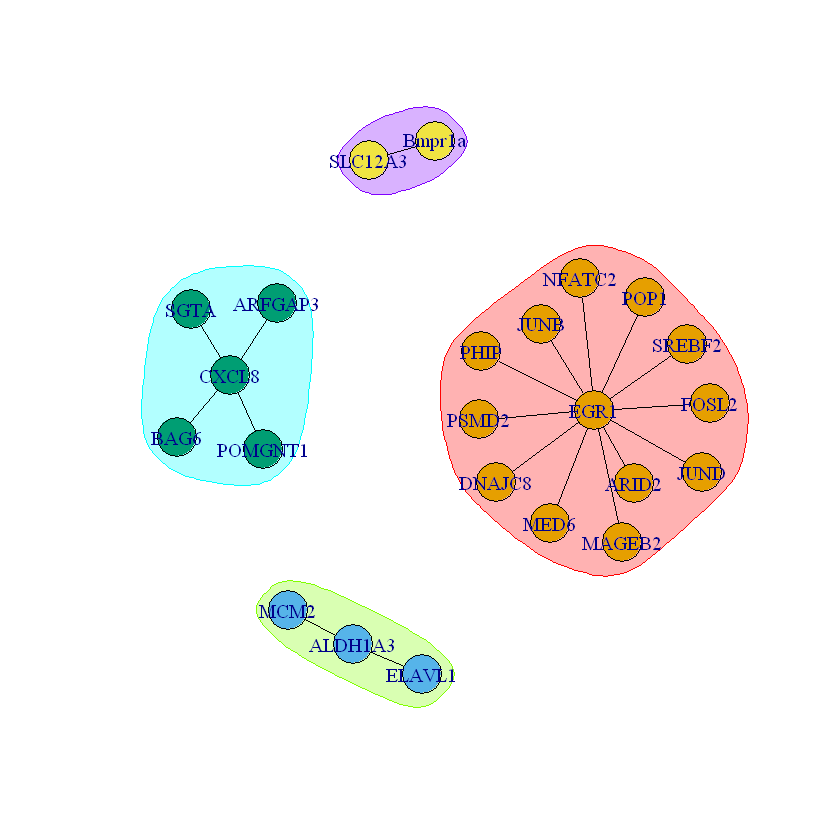

In [41]:
# Convertir el grafo dirigido en no dirigido
grafo_no_dirigido <- as.undirected(grafo, mode = "collapse")
# Detectar comunidades usando el algoritmo de Louvain en el grafo no dirigido
comunidades <- cluster_louvain(grafo_no_dirigido)
plot(comunidades, grafo_no_dirigido, layout = layout)


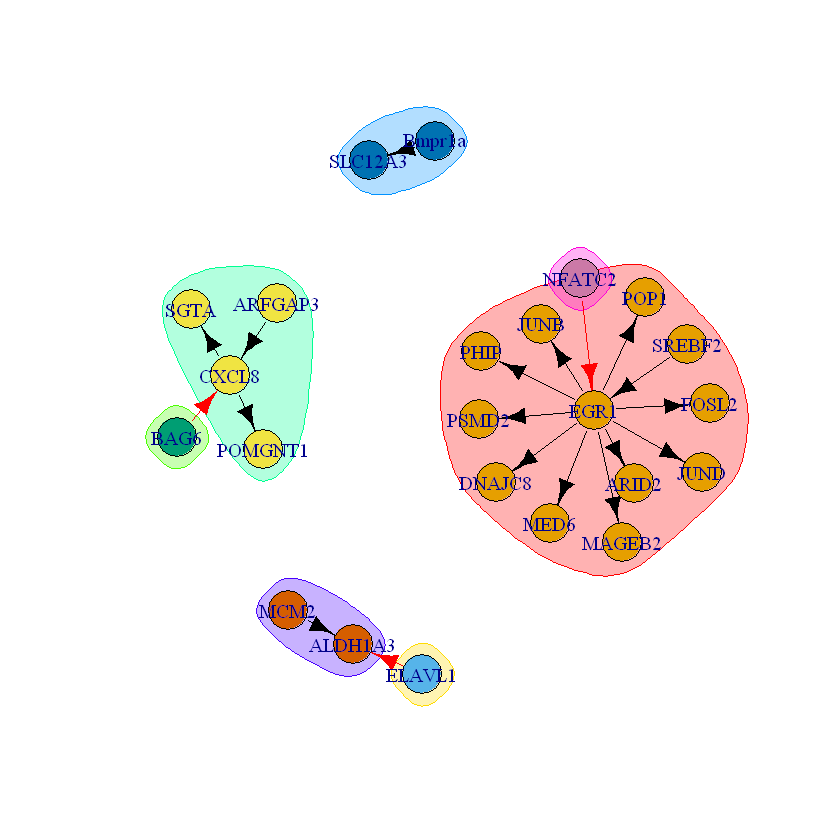

In [42]:
# Detectar comunidades usando el método de propagación de etiquetas en el grafo dirigido
comunidades_label_prop <- cluster_label_prop(grafo, weights = NA)
plot(comunidades_label_prop, grafo, layout = layout)


In [43]:
interacciones_fisicas

,V8,V9
,<chr>,<chr>
26,SREBF2,EGR1
45,ELAVL1,ALDH1A3
67,BAG6,CXCL8
68,ARFGAP3,CXCL8
69,CXCL8,POMGNT1
70,CXCL8,SGTA
79,EGR1,FOSL2
80,EGR1,JUNB
81,EGR1,JUND


In [30]:
#Intenta leer el archivo TSV con manejo de líneas incompletas
interacciones <- read.table(text = result, sep = "\t", header = FALSE, fill = TRUE)
str(interacciones)

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
"EOF within quoted string"


'data.frame':	94 obs. of  24 variables:
 $ V1 : int  5262 5271 255330 255331 255764 263015 263016 263017 263018 276384 ...
 $ V2 : int  2033 1387 1958 1958 3576 1387 2033 2033 1387 1958 ...
 $ V3 : int  1958 1958 1051 1051 6382 1958 1958 1958 1958 4665 ...
 $ V4 : int  108347 107777 108278 108278 109790 107777 108347 108347 107777 108278 ...
 $ V5 : int  108278 108278 107480 107480 112284 108278 108278 108278 108278 110747 ...
 $ V6 : chr  "RP1-85F18.1" "-" "-" "-" ...
 $ V7 : chr  "-" "-" "PP9092" "PP9092" ...
 $ V8 : chr  "EP300" "CREBBP" "EGR1" "EGR1" ...
 $ V9 : chr  "EGR1" "EGR1" "CEBPB" "CEBPB" ...
 $ V10: chr  "KAT3B|RSTS2|p300" "CBP|KAT3A|RSTS" "AT225|G0S30|KROX-24|NGFI-A|TIS8|ZIF-268|ZNF225" "AT225|G0S30|KROX-24|NGFI-A|TIS8|ZIF-268|ZNF225" ...
 $ V11: chr  "AT225|G0S30|KROX-24|NGFI-A|TIS8|ZIF-268|ZNF225" "AT225|G0S30|KROX-24|NGFI-A|TIS8|ZIF-268|ZNF225" "C/EBP-beta|IL6DBP|NF-IL6|TCF5" "C/EBP-beta|IL6DBP|NF-IL6|TCF5" ...
 $ V12: chr  "Two-hybrid" "Two-hybrid" "Two-hybrid" "Recon

https://wiki.thebiogrid.org/doku.php/biogrid_tab_version_2.0
Header Definitions
The first line of a BioGRID Tab 2.0 file is the heading line and starts with a hash (#). This line is purely for informational purposes and gives a brief description of the content contained in each column. If you are scripting the use of this file, you can simply ignore it.

Interaction File Column Definitions
The column contents of BioGRID Interaction Tab 2.0 files should be as follows:

BioGRID Interaction ID. A unique identifier for each interaction within the BioGRID database. Can be used to link to BioGRID interaction pages. For example: http://thebiogrid.org/interaction/616539
-Entrez Gene ID for Interactor A. The identifier from the Entrez-Gene database that corresponds to Interactor A. If no Entrez Gene ID is available, this will be a “-”.
-Entrez Gene ID for Interactor B. Same structure as column 2.
BioGRID ID for Interactor A. The identifier in the BioGRID database that corresponds to Interactor A. These identifiers are best used for creating links to the BioGRID from your own websites or applications. To link to a page within our site, simply append the URL: http://thebiogrid.org/ID/ to each ID. For example, http://thebiogrid.org/31623/.
BioGRID ID for Interactor B. Same structure as column 4.
Systematic name for Interactor A. A plain text systematic name if known for interactor A. Will be a “-” if no name is available.
Systematic name for Interactor B. Same structure as column 6.
Official symbol for Interactor A. A common gene name/official symbol for interactor A. Will be a “-” if no name is available.
Official symbol for Interactor B. Same structure as column 8.
Synonyms/Aliases for Interactor A. A “|” separated list of alternate identifiers for interactor A. Will be “-” if no aliases are available.
Synonyms/Aliases for Interactor B. Same stucture as column 10.
Experimental System Name. One of the many Experimental Evidence Codes supported by the BioGRID.
Experimental System Type. This will be either “physical” or “genetic” as a classification of the Experimental System Name.
First author surname of the publication in which the interaction has been shown, optionally followed by additional indicators, e.g. Stephenson A (2005)
Pubmed ID of the publication in which the interaction has been shown.
Organism ID for Interactor A. This is the NCBI Taxonomy ID for Interactor A.
Organism ID for Interactor B. Same structure as 16.
Interaction Throughput. This will be either High Throughput, Low Throughput or Both (separated by “|”).
Quantitative Score. This will be a positive for negative value recorded by the original publication depicting P-Values, Confidence Score, SGA Score, etc. Will be “-” if no score is reported.
Post Translational Modification. For any Biochemical Activity experiments, this field will be filled with the associated post translational modification. Will be “-” if no modification is reported.
Phenotypes. If any phenotype info is recorded, it will be provided here separated by “|”. Each phenotype will be of the format <phenotype>[<phenotype qualifier>]:<phenotype type>. Note that the phenotype types and qualifiers are optional and will only be present where recorded. Phenotypes may also have multiple qualifiers in which case unique qualifiers will be separated by carat (^). If no phenotype information is available, this field will contain “-”.
Qualifications. If additional plain text information was recorded for an interaction, it will be listed with unique qualifiers separated by “|”. If no qualification is available, this field will contain “-”.
Tags. If an interaction has been tagged with additional classifications, they will be provided in this column separated by “|”. If no tag information is available, this field will contain “-”.
Source Database. This field will contain the name of the database in which this interaction was provided.
All columns are mandatory so columns with no values are filled with “-“

In [32]:
# Guardar la lista de proteínas en un archivo CSV
write.csv(interacciones, file = "interacciones.csv", row.names = FALSE)

In [31]:
print(query_url)

[1] "http://webservice.thebiogrid.org/interactions?geneList=220|3576|1958|6559&searchids=true&includeInteractors=true&accesskey=2a4e2455be91b4c686b17f26b16cdeb9"


In [35]:
# Especifica la ruta de tu archivo interacciones.txt
file_path <- "interactions.txt"

# Leer el archivo de interacciones
interacciones <- read.table(file_path, sep = "\t", header = FALSE, fill = TRUE)
str(interacciones)

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
"EOF within quoted string"


'data.frame':	94 obs. of  24 variables:
 $ V1 : int  5262 5271 255330 255331 255764 263015 263016 263017 263018 276384 ...
 $ V2 : int  2033 1387 1958 1958 3576 1387 2033 2033 1387 1958 ...
 $ V3 : int  1958 1958 1051 1051 6382 1958 1958 1958 1958 4665 ...
 $ V4 : int  108347 107777 108278 108278 109790 107777 108347 108347 107777 108278 ...
 $ V5 : int  108278 108278 107480 107480 112284 108278 108278 108278 108278 110747 ...
 $ V6 : chr  "RP1-85F18.1" "-" "-" "-" ...
 $ V7 : chr  "-" "-" "PP9092" "PP9092" ...
 $ V8 : chr  "EP300" "CREBBP" "EGR1" "EGR1" ...
 $ V9 : chr  "EGR1" "EGR1" "CEBPB" "CEBPB" ...
 $ V10: chr  "KAT3B|RSTS2|p300" "CBP|KAT3A|RSTS" "AT225|G0S30|KROX-24|NGFI-A|TIS8|ZIF-268|ZNF225" "AT225|G0S30|KROX-24|NGFI-A|TIS8|ZIF-268|ZNF225" ...
 $ V11: chr  "AT225|G0S30|KROX-24|NGFI-A|TIS8|ZIF-268|ZNF225" "AT225|G0S30|KROX-24|NGFI-A|TIS8|ZIF-268|ZNF225" "C/EBP-beta|IL6DBP|NF-IL6|TCF5" "C/EBP-beta|IL6DBP|NF-IL6|TCF5" ...
 $ V12: chr  "Two-hybrid" "Two-hybrid" "Two-hybrid" "Recon